In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo
from exoplanet.gp import terms, GP
from exoplanet import estimate_inverse_gamma_parameters
from lightkurve.utils import TessQualityFlags
from maelstrom.utils import amplitude_spectrum

def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0 / 72.00  # Convert pt to inches
    golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Most aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt  # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width * golden_mean
    return [fig_width, fig_height]

In [2]:
plt.style.use('science')

In [3]:
lc = lk.search_lightcurvefile('21 Com', mission='TESS').download_all(quality_bitmask="none").SAP_FLUX.stitch().remove_nans()

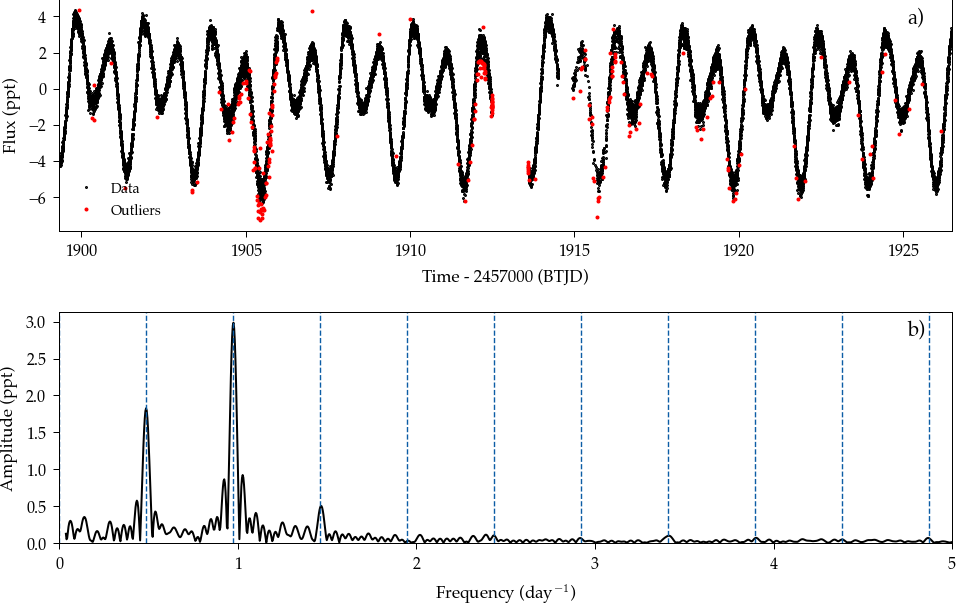

In [4]:
from scipy.signal import savgol_filter
fig, axes = plt.subplots(2,1,figsize=[8, 5])

ax = axes[0]
tq = TessQualityFlags
bitmask = tq.create_quality_mask(lc.quality, bitmask='hard')

x = lc.time[bitmask]#["TIME"][m]
y = lc.flux[bitmask]#["FLUX"][m]
yerr = lc.flux_err[bitmask]
mu = np.median(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu


# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = (resid < 3 * sigma)# | (resid <  -3 * sigma)
m &= (resid > -3 * sigma)

# Plot the data
ax.plot(x, y, ".k", label="Data", markersize=1, rasterized=True)
ax.plot(x[~m], y[~m], ".r", label="Outliers", markersize=2, rasterized=True)
ax.set_xlim(x.min(), x.max())
ax.set_xlabel("Time - 2457000 (BTJD)")
ax.set_ylabel("Flux (ppt)")
ax.annotate('a)', (0.95, 0.9), xycoords='axes fraction')

ax.legend(loc='best', fontsize=7)

# ax.set_yticks([-10, -5,-2.5,0,2.5])
# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

freq, amp = amplitude_spectrum(x,y, fmax=10)
ax =axes[1]

ax.plot(freq, amp, 'k')
ax.set_xlim(0,5)
ax.set_ylim(0,None)
plt.subplots_adjust(hspace=0.35)
ax.annotate('b)', (0.95, 0.9), xycoords='axes fraction')
f0 = 0.48721608
for i in range(11):
    ax.axvline(f0*i, lw=0.7, linestyle='dashed')
ax.set(xlabel=r'Frequency (day$^{-1}$)', ylabel='Amplitude (ppt)')
# plt.savefig('figures/lc_clean.pdf')

In [10]:
np.savetxt('lc.txt', list(zip(x, y, yerr)))

# Harmonic fitting

In [5]:
from astropy.timeseries import LombScargle

def amplitude_spectrum(t, y, fmin=None, fmax=None, oversample_factor=10.0):
    
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

In [7]:
from scipy.optimize import curve_fit

def harmonic_model(time, *theta):
    theta = np.array(theta)
    freq = theta[:1]
    freqs = np.array([freq*i for i in range(1,harmonics+1)]).squeeze()
    cut = theta[1:]
    amp = cut[:len(cut) // 2]
    phi = cut[len(cut) // 2:]
    model = np.sum(amp[:,None] * np.cos((2 * np.pi * freqs[:,None] * (time - 0.)) + phi[:,None]), axis=0)
    return model
    
def dft_phase(x, y, f):
    expo = 2.0 * np.pi * f * x
    ft_real = np.sum(y * np.cos(expo))
    ft_imag = np.sum(y * np.sin(expo))
    return np.arctan2(ft_imag, ft_real)

def harmonic_fit(time, flux, freq:float, harmonics, diagnose=True):
    # Never ask me to do this again
    freqs = np.array([freq*i for i in range(1,harmonics+1)])
    phases = np.array([dft_phase(time, flux, f) for f in freqs])
    amps = []
    for f in freqs:
        sc = LombScargle(x, y).power(f, method="fast", normalization="psd")
        amps.append(np.sqrt(sc) * np.sqrt(4.0 / len(time)))
        
    theta = np.hstack([freq, amps, phases])
    res = least_squares(harmonic_model, theta, args=(time, flux, harmonics), full_output=0)
    freq = res.x[:1]
    freqs = np.array([freq*i for i in range(1,harmonics+1)]).squeeze()
    theta = np.hstack([freqs, res.x[1:]]).reshape((3, len(freqs)))
    return theta, res


In [8]:
freq, harmonics = 0.48703637, 5
time, flux = x, y
freqs = np.array([freq*i for i in range(1,harmonics+1)])
phases = np.array([dft_phase(time, flux, f) for f in freqs])
amps = []
for f in freqs:
    sc = LombScargle(x, y).power(f, method="fast", normalization="psd")
    amps.append(np.sqrt(sc) * np.sqrt(4.0 / len(time)))

theta = np.hstack([freq, amps, phases])

popt, pcov = curve_fit(harmonic_model, time, flux, theta)
perr = np.sqrt(np.diag(pcov))

# Parse output.. may god forgive me
cut = popt[1:]
amp, phase = np.reshape(cut, (2, harmonics))
m = amp < 0
amp[m] *= -1.
phase[m] += np.pi

perrcut = perr[1:]
amperr, phaserr = np.reshape(perrcut, (2, harmonics))

freq = popt[:1]
freqs = np.array([freq*i for i in range(1,harmonics+1)]).T
ferr = perr[:1]

print(f"Freq: {freqs[0]} +\- {ferr} \n \
      Amps: {amp} +\- {amperr} \n \
      Phase: {phase} +\- {phaserr}")

Freq: [0.48720251 0.97440502 1.46160753 1.94881005 2.43601256] +\- [1.70087985e-05] 
       Amps: [1.73376894 2.91347469 0.35825311 0.08153559 0.06076911] +\- [0.00563665 0.00560223 0.00556255 0.00559099 0.00557215] 
       Phase: [  1.22305275  -7.62187219  -4.0278782  -10.22576429 -17.41058048] +\- [0.20451393 0.40886669 0.61362932 0.82055777 1.0267549 ]


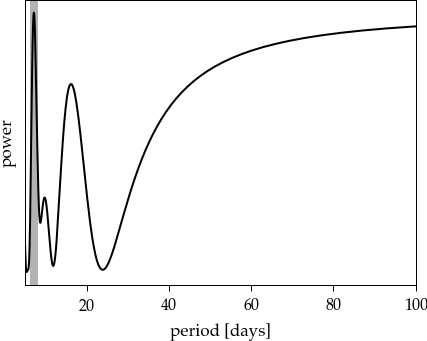

In [5]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
plt.ylabel("power");

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
#     map_soln = xo.optimize(start=model.test_point)

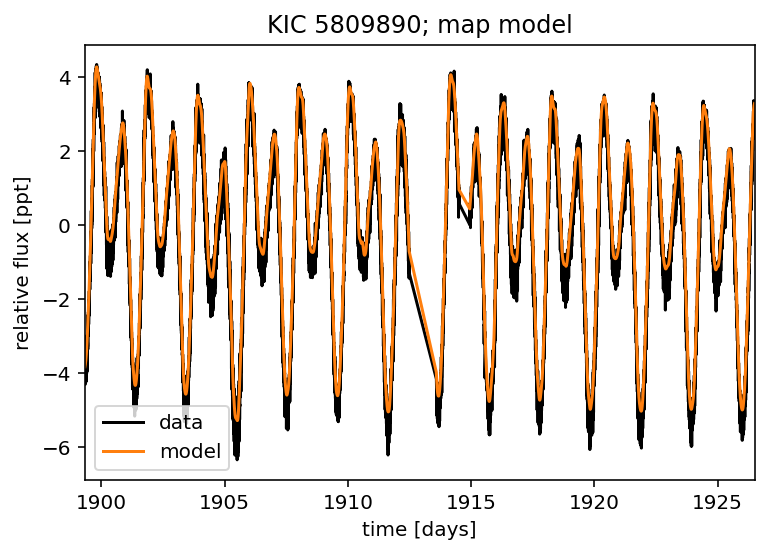

In [13]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

In [14]:
# np.random.seed(777)
# with model:
#     trace = xo.sample(tune=2500, draws=2000, start=map_soln, target_accept=0.95)
# pm.save_trace(trace, '21com')

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 9000/9000 [44:11<00:00,  3.39draws/s]  


In [7]:
with model:
    trace = pm.load_trace('21com')

In [9]:
pm.summary(
    trace,
    var_names=[
        "mix",
        "logdeltaQ",
        "logQ0",
        "logperiod",
        "logamp",
        "logSw4",
        "logw0",
        "logs2",
        "mean",
    ],
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mix,0.643,0.243,0.215,0.998,0.004,0.003,3726.0,3525.0,3296.0,2422.0,1.0
logdeltaQ,2.385,10.333,-17.205,20.529,0.162,0.180,4055.0,1654.0,4058.0,2967.0,1.0
logQ0,15.466,4.729,8.428,24.487,0.096,0.073,2430.0,2082.0,3296.0,2195.0,1.0
logperiod,0.719,0.000,0.718,0.720,0.000,0.000,4223.0,4223.0,4047.0,2724.0,1.0
logamp,1.654,0.861,0.162,3.331,0.016,0.013,2927.0,2043.0,3583.0,1974.0,1.0
logSw4,5.483,0.106,5.295,5.696,0.002,0.001,4920.0,4898.0,4952.0,2519.0,1.0
logw0,2.241,0.058,2.127,2.347,0.001,0.001,4940.0,4940.0,4941.0,2980.0,1.0
logs2,-2.916,0.013,-2.940,-2.891,0.000,0.000,4532.0,4532.0,4539.0,2866.0,1.0
mean,-0.309,0.049,-0.405,-0.219,0.001,0.001,5114.0,4756.0,5132.0,2679.0,1.0


In [8]:
med = np.median(trace['pred'], axis=0)
sd = np.std(trace['pred'], axis=0)

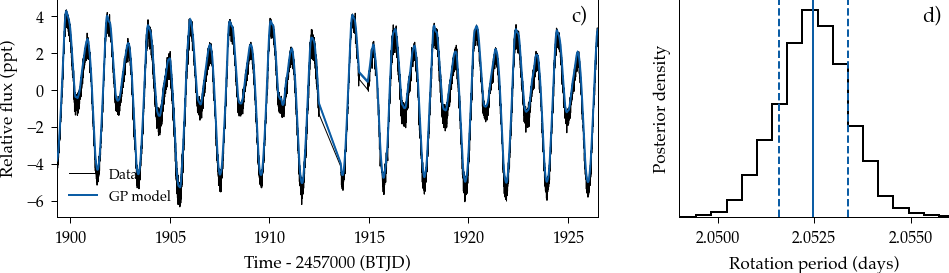

In [53]:
fig, axes = plt.subplots(1,2, figsize=[8, 2], gridspec_kw={'width_ratios': [2,1]})

ax = axes[0]
ax.plot(x, y, "k", lw=0.5, rasterized=True, markersize=1, zorder=1, label='Data')
ax.plot(x, med, zorder=50, label='GP model')
ax.fill_between(x, 1*(med-2*sd), 1*(med+2*sd), alpha=0.7)
# ax.plot(x, trace['pred'][0], c='blue', lw=0.1, alpha=0.1, label='model')

ax.legend(loc='best', fontsize=7)
# for tr in trace['pred'][np.random.choice(len(trace['pred']), size=100)]:
#     ax.plot(x, tr, c='blue', lw=0.2, alpha=0.1, rasterized=True, zorder=50)
    
ax.set_xlim(x.min(), x.max())
ax.set_xlabel("Time - 2457000 (BTJD)")
ax.set_ylabel("Relative flux (ppt)")
ax.annotate('c)', (0.95, 0.9), xycoords='axes fraction')

ax = axes[1]
period_samples = trace["period"]
# bins = np.linspace(20, 45, 40)
ax.hist(period_samples, histtype="step", color="k", bins=30)
ax.set_xlim(2.049, 2.056)
ax.set_yticks([])
ax.set_xticks([2.05, np.round(perc[1], 4), 2.055])
# plt.xlim(bins.min(), bins.max())
ax.set_xlabel("Rotation period (days)")
ax.set_ylabel("Posterior density");
ax.annotate('d)', (0.9, 0.9), xycoords='axes fraction')
# ax.text(0.1,0.1,'hi')
perc = np.percentile(period_samples, [16, 50, 84])
ax.axvline(perc[1])
ax.axvline(perc[0], linestyle='--')
ax.axvline(perc[2], linestyle='--')
plt.savefig('figures/model.pdf')

In [52]:
print(f"Rotation period is {perc[1]:.3f} + {perc[1] - perc[0]:.3f} - {perc[2] - perc[1]:.3f}")

Rotation period is 2.052 + 0.001 - 0.001


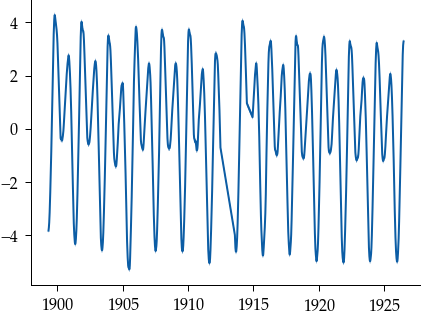

In [48]:
plt.plot(x, med, zorder=50)
plt.fill_between(x, 1*(med-2*sd), 1*(med+2*sd), alpha=0.7)

In [ ]:
med = np.median(trace['pred'], axis=0)
sd = np.std(trace['pred'], axis=0)

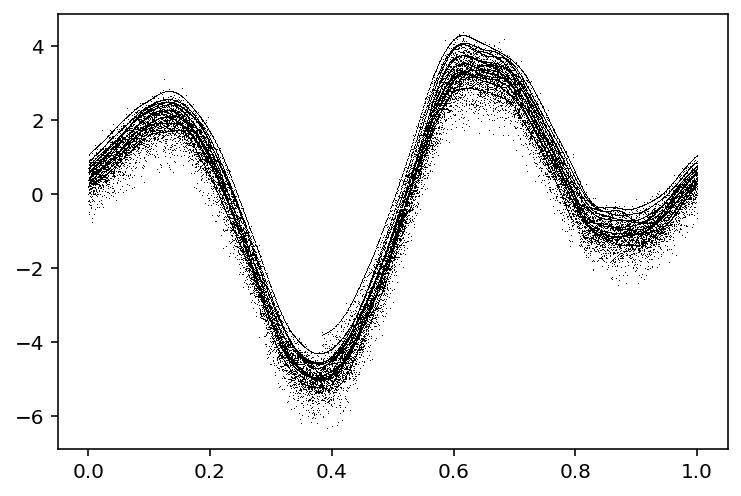

In [56]:
plt.plot(x % np.median(period_samples) /  np.median(period_samples), y, ",k")

plt.plot(x % np.median(period_samples) /  np.median(period_samples), med, ',k')

In [37]:
trace

<MultiTrace: 2 chains, 2000 iterations, 13 variables>

In [57]:
print(f"{np.median(period_samples):.4f}, {np.std(period_samples):.4f}")

2.0525, 0.0009


In [58]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [60]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@article{exoplanet:foremanmackey17,
   author = {{Foreman-Mackey}, D. and {Agol},

In [57]:
t = x

In [58]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
from exoplanet import estimate_inverse_gamma_parameters

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0)
    S1 = pm.InverseGamma(
        "S1", **estimate_inverse_gamma_parameters(0.5 ** 2, 10.0 ** 2)
    )
    S2 = pm.InverseGamma(
        "S2", **estimate_inverse_gamma_parameters(0.25 ** 2, 1.0 ** 2)
    )
    w1 = pm.InverseGamma(
        "w1", **estimate_inverse_gamma_parameters(2 * np.pi / 10.0, np.pi)
    )
    w2 = pm.InverseGamma(
        "w2", **estimate_inverse_gamma_parameters(0.5 * np.pi, 2 * np.pi)
    )
    log_Q = pm.Uniform("log_Q", lower=np.log(2), upper=np.log(10))

    # Set up the kernel an GP
    kernel = terms.SHOTerm(S_tot=S1, w0=w1, Q=1.0 / np.sqrt(2))
    kernel += terms.SHOTerm(S_tot=S2, w0=w2, log_Q=log_Q)
    gp = GP(kernel, t, yerr ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=y)

In [64]:
0.5 * np.pi

1.5707963267948966

In [59]:
with model:
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [log_Q, w2, w1, S2, S1, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -59065.80987536015 -> -2507.4884706726134


In [60]:
map_soln

{'mean': array(-0.35036546),
 'S1_log__': array(1.87956069),
 'S2_log__': array(-2.79018483),
 'w1_log__': array(1.40252108),
 'w2_log__': array(7.37911367),
 'log_Q_interval__': array(-7.80433431),
 'S1': array(6.55062646),
 'S2': array(0.06140986),
 'w1': array(4.06543636),
 'w2': array(1602.16908316),
 'log_Q': array(0.6938035)}

In [25]:
1/(4.065 / (2*np.pi))

1.5456790423566016